In [208]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import cho_solve, cho_factor
from tqdm import tqdm

import sys
np.set_printoptions(precision=4, linewidth=200, sign=" ")

## Useful functions from pose_graph_jacobian.ipynb
Just functions for `Exp` and `Log` maps, `cross` product matrix function and calculation of the jacobian

In [209]:
def np_cross(x):
    return np.array([
        [0,-x[2],x[1]],
        [x[2],0,-x[0]],
        [-x[1],x[0],0]
    ])

def np_exp(x):
    theta = np.linalg.norm(x[3:])
    if theta == 0:
        R = np.eye(3)
        t = x[:3]
    else:
        a = np.sin(theta)/theta
        b = (1 - np.cos(theta))/(theta*theta)
        c = (theta - np.sin(theta))/(theta**3)
        w = np_cross(x[3:])
        R = np.eye(3) + a*w + b*w@w

        t = (np.eye(3) + b*w + c*w@w)@x[:3]
    
    mat = np.eye(4)
    mat[:3, :3] = R
    mat[:3, 3] = t

    return mat

def np_log(T):
    theta = np.arccos(np.clip((np.trace(T) - 2) / 2, -1, 1))
    # theta = np.arccos((T[0, 0] + T[1, 1] + T[2, 2] - 1) / 2)


    if theta == 0:
        return np.array([T[0, 3], T[1, 3], T[2, 3], 0, 0, 0
])
    a = np.sin(theta)/theta
    b = (1 - np.cos(theta))/(theta*theta)

    x4 = 1/(2*a)*(T[2, 1] - T[1, 2])
    x5 = 1/(2*a)*(T[0, 2] - T[2, 0])
    x6 = 1/(2*a)*(T[1, 0] - T[0, 1])
    
    w = np_cross(np.array([x4,x5,x6]))
    u = (np.eye(3) - 1/2*w + 1/(theta**2)*(1 - a/(2*b))*w@w)@T[:3, 3]

    return np.array([u[0], u[1], u[2], x4, x5, x6])

In [210]:
def np_adjoint(X):
    """X is a 4x4 matrix not a 6 Vector"""
    mat = np.zeros((6,6))
    mat[:3,:3] = X[:3,:3]
    mat[3:,3:] = X[:3,:3]
    mat[:3,3:] = np_cross(X[:3,3])@X[:3,:3]

    return mat.T

def np_error(Z, Xi, Xj):
    return np_log(np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi))@np_exp(Xj))

def np_exp_error(Z, Xi, Xj):
    return np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi))@np_exp(Xj)

In [211]:
def box_plus(a, b):
    return np_log(np_exp(a)@np_exp(b))

def box_minus(a, b):
    return np_log(np.linalg.inv(np_exp(b))@np_exp(a))

In [212]:
def Je_analytic_Xi(Z, Xi, Xj):
    eXi, eXj = np_exp(Xi), np_exp(Xj)
    A = np.zeros((6,6))
    A[:3,:3] = (eXj[:3,:3]).T
    A[3:,3:] = (eXj[:3,:3]).T
    A[:3,3:] = -(eXj[:3,:3]).T@np_cross(eXj[:3,3])

    B = np.zeros_like(A)
    B[:3, :3] = eXi[:3,:3]
    B[3:,3:] = eXi[:3,:3]
    B[:3,3:] = np_cross(eXi[:3, 3])@eXi[:3,:3]

    return -A@B

def Je_analytic_Xj(Z, Xi, Xj):
    return np.eye(6)

In [213]:
def Je_numeric_Xi(Z, Xi, Xj, eps=1E-8, type_=np.float64):    
    Z, Xi, Xj = Z.astype(type_), Xi.astype(type_), Xj.astype(type_)

    generators = [np.array([i==j for i in range(6)], dtype=type_) for j in range(6)]

    error = np_exp_error(Z, Xi, Xj)
    # error_inv = np.linalg.inv(np_exp_error(Z, Xi, Xj))
    # gen_error = [np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi)@np_exp(g_i*eps))@np_exp(Xj) for g_i in generators]
    gen_error = [np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi + g_i*eps))@np_exp(Xj) for g_i in generators]
    # gen_error = [np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi + g_i*eps))@np_exp(Xj) for g_i in generators]

    # cols = (1/eps)*np.array([np_log(error_inv@gen_error_i) for gen_error_i in gen_error]).T
    try:
        cols = (1/eps)*np.array([np_log(gen_error_i) - np_log(error) for gen_error_i in gen_error]).T
    except TypeError:
        print(gen_error)
        print(error)
        raise

    return cols


def Je_numeric_Xj(Z, Xi, Xj, eps=1E-8, type_=np.float64):    
    Z, Xi, Xj = Z.astype(type_), Xi.astype(type_), Xj.astype(type_)

    generators = [np.array([i==j for i in range(6)], dtype=type_) for j in range(6)]

    error = np_exp_error(Z, Xi, Xj)
    # error_inv = np.linalg.inv(np_exp_error(Z, Xi, Xj))
    # gen_error = [np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi))@(np_exp(Xj)@np_exp(g_i*eps))for g_i in generators]
    gen_error = [np.linalg.inv(np_exp(Z))@np.linalg.inv(np_exp(Xi))@np_exp(Xj + g_i*eps) for g_i in generators]


    # cols = (1/eps)*np.array([np_log(error_inv@gen_error_i) for gen_error_i in gen_error]).T
    cols = (1/eps)*np.array([np_log(gen_error_i) - np_log(error) for gen_error_i in gen_error]).T

    return cols

## Setting up the pose graph problem
The plan here is to define a pose graph problem that is simple to solve and has a known correct solution - i.e. I can check that I'm converging on the right spot. To start with I think I'm going to go with 3 fully connected poses. I then calculate the correct measurements between them as my measurements, and set the information matrices to something reasonable. After that, displace the points and use these new points as my starting off point for the optimisation - if it correctly comes back to the original position then I'll know I've done something right and can move onto progressively harder problems.

In [214]:
n = 100
poses = [np_log(np_exp((np.random.random(6) - 0.5)*2)) for _ in range(n)]
measurements = {(i,j):np_log(np.linalg.inv(np_exp(poses[i]))@np_exp(poses[j])) for (i, j) in combinations(range(n), 2)}

eps = 0.1
disturbed_poses = [p + np.random.normal(0, eps, 6) if i else p for i, p in enumerate(poses)]
disturbed_poses[0] = poses[0]

infos = {k:np.linalg.inv(np.eye(6)*eps) for k in measurements.keys()}

# disturbed_poses, poses

### Take new measurements
So we are going to take all the consecutive measurements and then a few "loop closure" measurements and see what happens

In [215]:
# new_measures = {}
# for i in range(n - 1):
#     # print(measurements[(i,i+1)])
#     new_measures[(i, i + 1)] = measurements.pop((i,i+1))

# keys = tuple(measurements.keys())
# for i in np.random.choice(len(keys), 2):
#     new_measures[keys[i]] = measurements[keys[i]]

# measurements = new_measures
# len(new_measures)

Now that we have our poses, measurements and information matrices its time to get on with writing the actual optimisation code. We're going to use Gauss-Newton I think so the update rule is going to look like this:

$$\Delta x = (J^TJ)^{-1}J^Tr$$

In [216]:
def make_parts(poses, measurements, infos):
    H = np.zeros((6*len(poses), 6*len(poses)))
    b = np.zeros(6*len(poses))

    H[:6, :6] += np.eye(6)

    for (i, j), Zij in measurements.items():
        Xi, Xj = poses[i], poses[j]
        omega = infos[(i, j)]

        e = np_error(Zij, Xi, Xj)
        A = Je_numeric_Xi(Zij, Xi, Xj)
        B = Je_numeric_Xj(Zij, Xi, Xj)

        if np.any(np.isnan(e)):
            print("panique")
            # print(np.linalg.inv(np_exp(Xi)))
            # print(np_exp(Xj))
            # print(np.linalg.inv(np_exp(Zij)))
            print(np.linalg.inv(np_exp(Zij))@np.linalg.inv(np_exp(Xi))@np_exp(Xj))
            print(np_log(np.linalg.inv(np_exp(Zij))@np.linalg.inv(np_exp(Xi))@np_exp(Xj)))
            raise ValueError()

        H[6*i:6*i+6, 6*i:6*i+6] += A.T@omega@A
        H[6*i:6*i+6, 6*j:6*j+6] += A.T@omega@B
        H[6*j:6*j+6, 6*i:6*i+6] += B.T@omega@A
        H[6*j:6*j+6, 6*j:6*j+6] += B.T@omega@B

        b[6*i:6*i+6] += A.T@omega@e
        b[6*j:6*j+6] += B.T@omega@e

    return H, b

H, b = make_parts(disturbed_poses, measurements, infos)

H.shape, b.shape


((600, 600), (600,))

[array([-0.0089, -0.6277, -0.7578,  0.8641,  0.0322, -0.8456]), array([ 0.6483, -0.6692,  0.2136, -0.8837,  0.0114, -0.7869]), array([ 0.7182, -0.4014, -0.6431, -0.0215, -0.3352, -0.1054]), array([ 0.9324, -0.0487,  0.6912,  1.0183,  0.5247,  0.5753]), array([ 0.0829, -0.8844, -0.4093, -0.5592,  0.6528,  0.5359]), array([ 0.7666, -0.5388,  1.0033, -0.3884,  0.5036, -0.5423]), array([ 0.1081, -0.3836,  0.454 ,  0.6139,  0.5467, -0.0221]), array([ 0.9713,  0.1665, -0.4088,  0.0945,  0.9351, -0.4469]), array([-0.2641,  0.2511,  0.6591, -0.1786, -0.6947,  0.6476]), array([ 0.8861,  0.0762,  0.6184, -0.305 ,  0.0406, -0.8652]), array([-0.774 , -0.7382, -0.4731,  0.1904, -0.5317,  0.6272]), array([ 0.3969,  0.2859,  0.4345, -0.6834,  0.1309, -0.4014]), array([-0.3458, -0.2898,  0.0337,  0.0818, -0.5071, -1.0037]), array([-0.9977,  0.4484, -0.3543,  0.3083,  0.1081,  0.6015]), array([-0.393 , -0.5346, -0.1972, -0.8571,  0.202 ,  0.4951]), array([ 0.6926, -0.0594, -0.9337,  0.8422,  0.2735,  0

Max delta norm: 2.97615369701027e-13: 100%|██████████| 100/100 [08:13<00:00,  4.93s/it] 


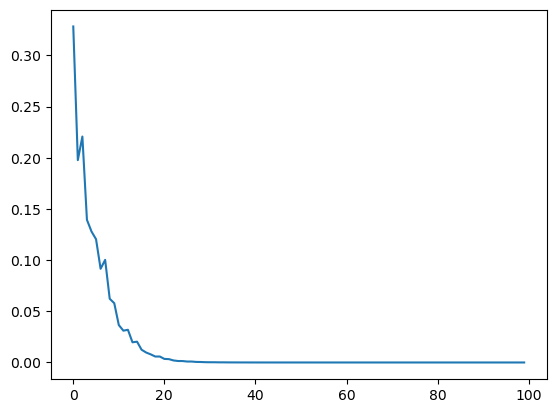

In [218]:
new_poses = disturbed_poses[:]
print([p for p in new_poses])

pbar = tqdm(range(100))
delta_store = []

for i in pbar:
    H, b = make_parts(new_poses, measurements, infos)
    # with np.printoptions(precision=4, suppress=True):
    #     print(H)
    try:
        delta = cho_solve(cho_factor(H), b)
    except ValueError as e:
        print(H)
        print(e)
        break
    pbar.set_description(f"Max delta norm: {np.max(np.abs(delta))}")
    delta_store.append(np.max(np.abs(delta)))
    pose_vector = np.concatenate(new_poses)
    for i in range(0, pose_vector.shape[0]//6):
        # new_poses[i] = np_log(np_exp(new_poses[i])@np_exp(delta[6*i:6*i + 6]))
        new_poses[i] = np_log(np.linalg.inv(np_exp(delta[6*i:6*i + 6]))@np_exp(new_poses[i]))
        # new_poses[i] += delta[6*i:6*i+6]
    # print([p for p in new_poses])


# print(new_poses)
# print(poses)
plt.plot(np.array(delta_store))

## Visualising the Optimisation
The plan is to visualise the optimisation process using open3d and some coloured dots.
- Red is the initial "bad" position of the 

In [ ]:
import open3d as o3d
from itertools import chain

In [ ]:
def create_axis(transform, colour, size=0.2):
    mesh = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=np.array([0.0,0.0,0.0]))
    mesh.paint_uniform_color(colour)
    mesh.transform(transform)
    return mesh

In [ ]:
true_poses = [create_axis(np_exp(x), [0,1,0]) for x in poses]
start_poses = [create_axis(np_exp(x), [1,0,0]) for x in disturbed_poses]
end_poses = [create_axis(np_exp(x), [0,0,1], 0.3) for x in new_poses]

# o3d.visualization.draw_geometries([x for x in chain(start_poses, true_poses, end_poses)])

In [ ]:
def create_error(start, error, colour, radius=0.005, resolution=20):
    end = start@error
    # Extract translation vectors from the matrices
    start_translation = np.array(start[:3, 3])
    end_translation = np.array(end[:3, 3])

    # Calculate the height of the cylinder
    height = np.linalg.norm(end_translation - start_translation)

    # Create a cylinder
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=height, resolution=resolution)

    # Calculate the rotation matrix to align the cylinder with the direction from start to end
    z = [0,0,1]
    direction = end_translation - start_translation
    dz = direction/np.linalg.norm(direction)
    dx = np.cross(dz, z)/np.linalg.norm(np.cross(dz, z))
    dy = np.cross(dz, dx)/np.linalg.norm(np.cross(dz, dx))

    rotation_matrix = np.vstack([dx,dy,dz]).T
    # print(rotation_matrix)
    # print(dx, dy, dz)

    # Apply the rotation and translation to the cylinder
    cylinder.translate(np.array([0, 0, height/2]))
    cylinder.rotate(rotation_matrix, center=(0,0,0))
    cylinder.translate(start_translation)
    cylinder.paint_uniform_color(colour)

    return cylinder

errors = [create_error(np_exp(poses[i]), np_exp(Zij), [0.7,0.7,0.7]) for (i, j), Zij in measurements.items()]

# o3d.visualization.draw_geometries([x for x in chain(errors, start_poses, end_poses, true_poses, [create_axis(np.eye(4), [0,0,0])])])


# np.sum([np.all(np.isclose(a, b)) for a, b in zip(new_poses, poses)])/len(poses)

for a,b in zip(new_poses, poses):
    print(np.isclose(a, b))
    print(a)
    print(b)
    print()

[ True  True  True  True  True  True]
[ 0.777   0.9874 -0.4402 -0.0884 -0.2262  0.4193]
[ 0.777   0.9874 -0.4402 -0.0884 -0.2262  0.4193]

[False False False False False False]
[ 0.7926 -0.6843  0.3747  0.9827  0.8143  0.3716]
[ 0.7928 -0.6838  0.3735  0.9827  0.8144  0.3714]

[ True  True  True  True  True False]
[-0.9354  0.5335  0.3818  0.3356  0.8477  0.1178]
[-0.9354  0.5335  0.3818  0.3356  0.8477  0.1178]

[False  True False False  True False]
[-0.7289  0.6344  0.0519 -0.5505 -0.9309  0.098 ]
[-0.7289  0.6344  0.0519 -0.5505 -0.9309  0.0979]

[ True  True  True False  True  True]
[-7.9866e-01  1.9403e-01  1.0926e-01  7.6709e-05 -6.1412e-01  2.3759e-01]
[-7.9866e-01  1.9403e-01  1.0926e-01  7.6788e-05 -6.1412e-01  2.3759e-01]

[False False False False False False]
[-0.1559  0.6448 -0.8241 -0.6988 -0.995  -0.3932]
[-0.1566  0.6452 -0.8244 -0.6988 -0.9951 -0.3931]

[False False False False False  True]
[ 0.5971 -0.9588  0.1043 -0.2166  0.4027  0.9483]
[ 0.597  -0.9589  0.1044 -0.21